Import Libraries


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_absolute_error, r2_score
from scipy.optimize import minimize_scalar
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve

Load and Inspect the Data


In [2]:
df = pd.read_csv("Data Files/deepthink_data.csv")
print("="*50)
print("DATA OVERVIEW")
print("="*50)
print("First few rows of the dataset:")
print(df.head())

# Calculate the average airplane capacity for each month for domestic flights
df['average_airplane_capacity_D'] = df['seats_D'] / df['flights_D']

# Calculate the average airplane capacity for each month for international flights
df['average_airplane_capacity_I'] = df['seats_I'] / df['flights_I']

# Calculate the overall average airplane capacity for domestic flights
average_airplane_capacity_D = df['average_airplane_capacity_D'].mean()

# Calculate the overall average airplane capacity for international flights
average_airplane_capacity_I = df['average_airplane_capacity_I'].mean()

# Print the results
print("\nAverage Airplane Capacity for Each Month for Domestic Flights:")
print(f"\nOverall Average Airplane Capacity (Domestic): {average_airplane_capacity_D:.2f}")

print("\nAverage Airplane Capacity for Each Month for International Flights:")
print(f"Overall Average Airplane Capacity (International): {average_airplane_capacity_I:.2f}")

DATA OVERVIEW
First few rows of the dataset:
   year     month  pax_D  seats_D  flights_D  avg_fare_D  pax_I  LF_D  LF_I  \
0  2000   January  48020    82000        420          25  32010  58.6  39.0   
1  2000  February  52015    85000        435          27  33500  61.2  40.5   
2  2000     March  61000   105000        510          29  40500  58.1  42.3   
3  2000     April  72300   115000        680          32  52000  62.9  54.2   
4  2000       May  88500   135000        720          34  63500  65.6  60.1   

   seats_I  flights_I  avg_fare_I  selling_prices  capacities_D  capacities_I  \
0    82000        310          55            45.2        100000      150000.0   
1    84000        325          58            47.8        100000      150000.0   
2    96000        410          62            52.1        120000      180000.0   
3   105000        520          65            58.3        130000      195000.0   
4   125000        630          68            63.7        150000      225000

Define Features and Targets


In [3]:
features_D = ['avg_fare_D', 'selling_prices', 'capacities_D', 'month_rank']
features_I = ['avg_fare_I', 'selling_prices', 'capacities_I', 'month_rank']
target_pax_D = 'pax_D'
target_pax_I = 'pax_I'

print("\n" + "="*50)
print("SUMMARY STATISTICS")
print("="*50)
print(df[features_D + features_I + [target_pax_D, target_pax_I]].describe())


SUMMARY STATISTICS
       avg_fare_D  selling_prices   capacities_D  month_rank  avg_fare_I  \
count  288.000000      288.000000     288.000000  288.000000  288.000000   
mean    43.062500       84.438403  190764.361111    6.500000   83.847222   
std     10.952364       28.543797  106138.055976    3.458061   23.683547   
min     25.000000       45.200000   96995.000000    1.000000   55.000000   
25%     36.000000       65.150000  130000.000000    3.750000   70.000000   
50%     41.000000       75.650000  167559.500000    6.500000   77.000000   
75%     47.250000       91.850000  197045.000000    9.250000   87.000000   
max     85.000000      172.280000  740250.000000   12.000000  174.000000   

       selling_prices  capacities_I  month_rank          pax_D         pax_I  
count      288.000000  2.880000e+02  288.000000     288.000000  2.880000e+02  
mean        84.438403  2.861466e+05    6.500000  177422.600694  1.909836e+05  
std         28.543797  1.592071e+05    3.458061  140093.64

Train/Test Split


In [4]:
X_train_D, X_test_D, y_train_D, y_test_D = train_test_split(
    df[features_D], df[target_pax_D], test_size=0.1, random_state=42
)
X_train_I, X_test_I, y_train_I, y_test_I = train_test_split(
    df[features_I], df[target_pax_I], test_size=0.1, random_state=42
)

print("\n" + "="*50)
print("TRAIN/TEST SPLIT")
print("="*50)
print(f"Domestic Training Samples: {len(X_train_D)}")
print(f"Domestic Testing Samples: {len(X_test_D)}")
print(f"International Training Samples: {len(X_train_I)}")
print(f"International Testing Samples: {len(X_test_I)}")


TRAIN/TEST SPLIT
Domestic Training Samples: 259
Domestic Testing Samples: 29
International Training Samples: 259
International Testing Samples: 29


Standardize Features


In [5]:
scaler_D = StandardScaler()
X_train_D = scaler_D.fit_transform(X_train_D)
X_test_D = scaler_D.transform(X_test_D)

scaler_I = StandardScaler()
X_train_I = scaler_I.fit_transform(X_train_I)
X_test_I = scaler_I.transform(X_test_I)

print("\n" + "="*50)
print("STANDARDIZED FEATURES (First 5 Rows)")
print("="*50)
print("Domestic:")
for row in X_train_D[:5]:
    print(row)
print("\nInternational:")
for row in X_train_I[:5]:
    print(row)


STANDARDIZED FEATURES (First 5 Rows)
Domestic:
[-1.17628013 -1.19053708 -0.86195706  1.57656766]
[ 0.09236703 -0.17604361 -0.19191645 -0.71420947]
[ 0.72669061  0.07139382  0.13353185 -0.71420947]
[ 0.00174938 -0.43762032 -0.23977649 -0.42786233]
[ 2.90151432  1.99327569  0.37589511 -1.28690375]

International:
[-1.01615695 -1.19053708 -0.86195699  1.57656766]
[-0.15859863 -0.17604361 -0.19191644 -0.71420947]
[ 0.14154679  0.07139382  0.13353183 -0.71420947]
[-0.33011029 -0.43762032 -0.23977648 -0.42786233]
[ 3.40026844  1.99327569  0.37589507 -1.28690375]


Train kNN Regression Models


In [6]:
n_neighbors = 5
model_D_knn = KNeighborsRegressor(n_neighbors=n_neighbors)
model_D_knn.fit(X_train_D, y_train_D)
y_pred_D_knn = model_D_knn.predict(X_test_D)

model_I_knn = KNeighborsRegressor(n_neighbors=n_neighbors)
model_I_knn.fit(X_train_I, y_train_I)
y_pred_I_knn = model_I_knn.predict(X_test_I)

print("\n" + "="*50)
print("PREDICTIONS (kNN Regression)")
print("="*50)
print("Domestic Predictions:")
print([float(x) for x in y_pred_D_knn])
print("Domestic Actuals:")
print(y_test_D.tolist())

print("\nInternational Predictions:")
print([float(x) for x in y_pred_I_knn])
print("International Actuals:")
print(y_test_I.tolist())


PREDICTIONS (kNN Regression)
Domestic Predictions:
[97800.0, 81800.0, 239480.4, 137800.0, 84000.0, 94100.0, 81000.0, 122400.0, 124800.0, 102000.0, 418836.0, 96400.0, 126400.0, 303599.2, 115200.0, 243966.0, 118500.0, 433680.0, 312498.6, 87800.0, 327042.6, 65000.0, 134800.0, 288870.8, 67000.0, 156572.4, 136000.0, 102200.0, 93800.0]
Domestic Actuals:
[96000, 81000, 275493, 138000, 85000, 85400, 80000, 123000, 126000, 109000, 460530, 94000, 124000, 399150, 114000, 198975, 105200, 386925, 341996, 89000, 322530, 65000, 132000, 480392, 67000, 257728, 128000, 101000, 95000]

International Predictions:
[80800.0, 50800.0, 469751.4, 98800.0, 50800.0, 72900.0, 66000.0, 95200.0, 90800.0, 152924.4, 709210.0, 80800.0, 99400.0, 478751.2, 94200.0, 211322.0, 85600.0, 805666.2, 530581.4, 63800.0, 465053.6, 41400.0, 96400.0, 366727.2, 42400.0, 140572.4, 101200.0, 78200.0, 69400.0]
International Actuals:
[78000, 50000, 301493, 98000, 52000, 68000, 65000, 94000, 92000, 85000, 838530, 76000, 103000, 730169,

Model Evaluation using Cross-Validation


In [7]:
cv_folds = 8    # Number of cross-validation folds for evaluation.

print("\n" + "="*50)
print("CROSS-VALIDATION RESULTS")
print("="*50)
cv_scores_D = cross_val_score(model_D_knn, scaler_D.transform(df[features_D]), df[target_pax_D], cv=cv_folds, scoring='r2')
cv_scores_I = cross_val_score(model_I_knn, scaler_I.transform(df[features_I]), df[target_pax_I], cv=cv_folds, scoring='r2')

print("Domestic R² Scores per Fold:", cv_scores_D)
print(f"Domestic Average R² Score: {cv_scores_D.mean():.2f}")
print("\nInternational R² Scores per Fold:", cv_scores_I)
print(f"International Average R² Score: {cv_scores_I.mean():.2f}")

mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv_mae_D = cross_val_score(model_D_knn, scaler_D.transform(df[features_D]), df[target_pax_D], cv=cv_folds, scoring=mae_scorer)
cv_mae_I = cross_val_score(model_I_knn, scaler_I.transform(df[features_I]), df[target_pax_I], cv=cv_folds, scoring=mae_scorer)

print("\nDomestic MAE per Fold (in absolute value):", [float(-score) for score in cv_mae_D])
print(f"Domestic Average MAE: {-cv_mae_D.mean():.2f}")
print("\nInternational MAE per Fold (in absolute value):", [float(-score) for score in cv_mae_I])
print(f"International Average MAE: {-cv_mae_I.mean():.2f}")

train_r2_D = model_D_knn.score(X_train_D, y_train_D)
test_r2_D = model_D_knn.score(X_test_D, y_test_D)
train_r2_I = model_I_knn.score(X_train_I, y_train_I)
test_r2_I = model_I_knn.score(X_test_I, y_test_I)

print("\nDomestic Model:")
print(f"  Training R² Score: {train_r2_D:.2f}")
print(f"  Testing R² Score: {test_r2_D:.2f}")
print("\nInternational Model:")
print(f"  Training R² Score: {train_r2_I:.2f}")
print(f"  Testing R² Score: {test_r2_I:.2f}")


CROSS-VALIDATION RESULTS
Domestic R² Scores per Fold: [0.90784124 0.99065787 0.99341945 0.96214477 0.88445932 0.81643946
 0.36189948 0.07677098]
Domestic Average R² Score: 0.75

International R² Scores per Fold: [0.85665127 0.99386346 0.99791648 0.82174771 0.65410196 0.92562988
 0.51022347 0.20559362]
International Average R² Score: 0.75

Domestic MAE per Fold (in absolute value): [6335.138888888889, 2241.472222222222, 1801.111111111111, 4562.549999999999, 7654.3166666666675, 31326.449999999997, 81803.84999999999, 120006.35555555558]
Domestic Average MAE: 31966.41

International MAE per Fold (in absolute value): [7460.833333333333, 1529.388888888889, 866.6666666666666, 7970.372222222223, 6594.127777777777, 31730.555555555555, 113159.15000000001, 178633.41666666666]
International Average MAE: 43493.06

Domestic Model:
  Training R² Score: 0.92
  Testing R² Score: 0.86

International Model:
  Training R² Score: 0.88
  Testing R² Score: 0.89


Plot Learning Curves


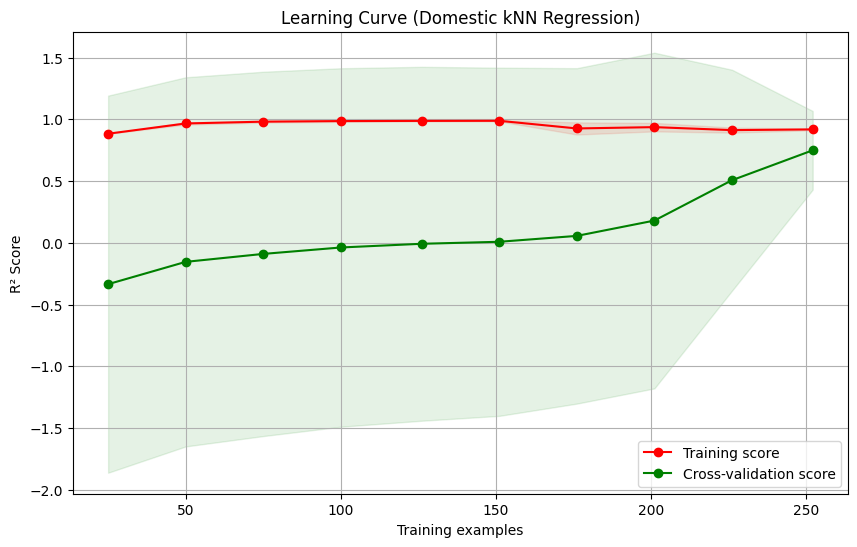

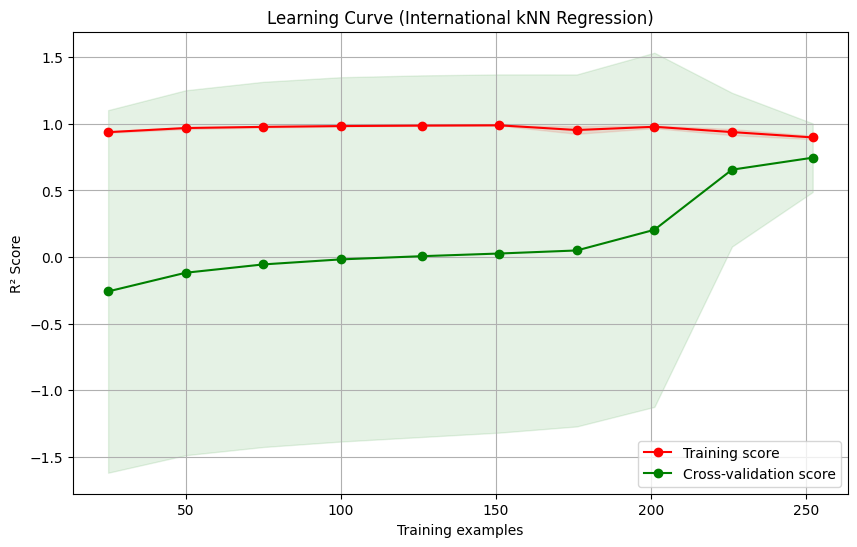

In [8]:
def plot_learning_curve(estimator, title, X, y, cv, n_jobs=1, train_sizes=np.linspace(0.1, 1.0, 10)):
    """
    Generates a plot of the training and cross-validation learning curves.
    
    Parameters:
      estimator: The model to evaluate.
      title: Title for the chart.
      X: Feature data.
      y: Target values.
      cv: Cross-validation splitting strategy.
      n_jobs: Number of jobs to run in parallel.
      train_sizes: Relative or absolute numbers of training examples that will be used to generate the learning curve.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("R² Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring='r2'
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid(True)
    
    # Plot the mean and std deviation for training scores
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    
    # Plot the mean and std deviation for cross-validation scores
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    
    plt.legend(loc="best")
    plt.show()

# Plot learning curve for the Domestic kNN model
plot_learning_curve(
    estimator=model_D_knn,
    title="Learning Curve (Domestic kNN Regression)",
    X=scaler_D.transform(df[features_D]),
    y=df[target_pax_D],
    cv=cv_folds,
    n_jobs=-1
)

# Plot learning curve for the International kNN model
plot_learning_curve(
    estimator=model_I_knn,
    title="Learning Curve (International kNN Regression)",
    X=scaler_I.transform(df[features_I]),
    y=df[target_pax_I],
    cv=cv_folds,
    n_jobs=-1
)

Interactive New Month Prediction & Optimization

In [ ]:

def optimize_domestic_fare():
    """
    This function finds the optimal domestic fare such that the predicted demand
    is as close as possible to the provided total capacity while ensuring that
    the fare remains realistic relative to the competitor's selling price.
    
    If the chosen domestic fare exceeds the competitor's selling price, the predicted 
    pax is scaled down proportionally, reflecting that a much higher fare would 
    result in lower demand. The effective load factor is computed based on the 
    adjusted predicted pax.
    
    In addition, using the overall average airplane capacity (average_airplane_capacity_D),
    we calculate how many flights are needed and the load factor per flight.
    """
    print("\n" + "="*50)
    print("OPTIMIZATION OF DOMESTIC FARE")
    print("="*50)
    try:
        init_avg_fare_D = float(input("Enter initial Average Fare for domestic (e.g., 27): "))
        selling_prices = float(input("Enter Selling Prices (e.g., 103.13): "))
        total_capacity = float(input("Enter Total Capacity for Domestic (e.g., 99837.0): "))
        month_rank = float(input("Enter Month's Rank (e.g., 10): "))
    except ValueError:
        print("Invalid input. Please enter numerical values.")
        return
    
    # Define the objective function: minimize (adjusted predicted pax - total_capacity)^2.
    def objective(avg_fare):
        new_features = pd.DataFrame({
            'avg_fare_D': [avg_fare],
            'selling_prices': [selling_prices],
            'capacities_D': [total_capacity],
            'month_rank': [month_rank]
        })
        new_features_scaled = scaler_D.transform(new_features)
        predicted = model_D_knn.predict(new_features_scaled)[0]
        # If the domestic fare is above the competitor's selling price,
        # scale down the predicted pax proportionally.
        adjustment_factor = selling_prices / avg_fare if avg_fare > selling_prices else 1
        adjusted_predicted = predicted * adjustment_factor
        return (adjusted_predicted - total_capacity) ** 2
    
    # Adjust the bounds based on month rank
    lower_bound = 10
    upper_bound = selling_prices * (1 + (12 - month_rank) / 12)  # Adjust upper bound based on month rank
    upper_bound = min(upper_bound, selling_prices * 1.2)  # Ensure the fare does not exceed 120% of selling_prices
    
    # Run the optimizer using the bounded method.
    res = minimize_scalar(objective, bounds=(lower_bound, upper_bound), method='bounded')
    optimal_fare = res.x
    
    # Get the corresponding predicted pax using the optimal fare.
    new_features = pd.DataFrame({
        'avg_fare_D': [optimal_fare],
        'selling_prices': [selling_prices],
        'capacities_D': [total_capacity],
        'month_rank': [month_rank]
    })
    new_features_scaled = scaler_D.transform(new_features)
    predicted = model_D_knn.predict(new_features_scaled)[0]
    adjustment_factor = selling_prices / optimal_fare if optimal_fare > selling_prices else 1
    optimal_predicted = predicted * adjustment_factor
    
    # Compute the effective load factor (capped at 100%).
    effective_LF = min(optimal_predicted, total_capacity) / total_capacity
    
    # Compute the number of flights needed based on the overall average airplane capacity.
    flights_needed = np.ceil(optimal_predicted / average_airplane_capacity_D)
    # Calculate the average load factor per flight.
    load_factor_per_flight = (optimal_predicted / flights_needed) / average_airplane_capacity_D
    
    print("\nFINAL OPTIMIZATION RESULTS (Domestic):")
    print(f"Optimal Average Fare for Domestic (adjusted): {optimal_fare:.2f}")
    print(f"Optimal Predicted Pax (adjusted): {optimal_predicted:.0f}")
    print(f"Provided Total Capacity: {total_capacity:.0f}")
    print(f"Effective Load Factor (with respect to the provided capacity): {effective_LF*100:.2f}%")
    print(f"Overall Average Airplane Capacity (Domestic): {average_airplane_capacity_D:.2f}")
    print(f"Estimated Number of Flights Needed: {int(flights_needed)}")
    print(f"Average Load Factor per Flight: {load_factor_per_flight*100:.2f}%")

def interactive_prediction():
    print("\n" + "="*50)
    print("INTERACTIVE NEW MONTH PREDICTION")
    print("="*50)
    try:
        avg_fare_D = float(input("Enter the Average Fare for Domestic (e.g. 27): "))
        avg_fare_I = float(input("Enter the Average Fare for International (e.g. 72): "))
        selling_prices = float(input("Enter Selling Prices e.g. 103.13): "))
        capacities_D = float(input("Enter Capacities for Domestic (e.g. 99837.0): "))
        capacities_I = float(input("Enter Capacities for International (e.g. 110000.0): "))
        month_rank = float(input("Enter the Month's Rank (e.g. 10): "))
    except ValueError:
        print("Invalid input. Please enter numerical values.")
        return

    new_features_D = pd.DataFrame([[avg_fare_D, selling_prices, capacities_D, month_rank]], columns=features_D)
    new_features_I = pd.DataFrame([[avg_fare_I, selling_prices, capacities_I, month_rank]], columns=features_I)
    
    new_features_D_scaled = scaler_D.transform(new_features_D)
    new_features_I_scaled = scaler_I.transform(new_features_I)
    
    pred_pax_D = model_D_knn.predict(new_features_D_scaled)[0]
    pred_pax_I = model_I_knn.predict(new_features_I_scaled)[0]
    
    print("\n--- Prediction Results ---")
    print(f"Predicted Domestic Passengers (pax_D): {pred_pax_D:.0f}")
    print(f"Predicted International Passengers (pax_I): {pred_pax_I:.0f}")

Run Interactive Components

In [10]:

interactive_prediction()
optimize_domestic_fare()


INTERACTIVE NEW MONTH PREDICTION

--- Prediction Results ---
Predicted Domestic Passengers (pax_D): 78200
Predicted International Passengers (pax_I): 62800

OPTIMIZATION OF DOMESTIC FARE

FINAL OPTIMIZATION RESULTS (Domestic):
Optimal Average Fare for Domestic (adjusted): 49.67
Optimal Predicted Pax (adjusted): 114800
Provided Total Capacity: 150000
Effective Load Factor (with respect to the provided capacity): 76.53%
Overall Average Airplane Capacity (Domestic): 183.51
Estimated Number of Flights Needed: 626
Average Load Factor per Flight: 99.93%
